In [1]:
import os, sys, glob
import re

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
font = {'family' : 'IBM Plex Sans',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# parallel
from multiprocessing import Pool
from joblib import Parallel, delayed

# geo
import geopandas as gpd
import rtree
from shapely.geometry import shape, mapping, Point, LinearRing

In [3]:
Client().send_message("Starting run on Yen")

In [2]:
home_root = '/home/alal/Dropbox/1_Research/India_Forests'
yen_root  = '/home/users/apoorval/Research/India_Forests'
root = Path(home_root)

In [3]:
code = root / 'Code'
data = root / 'Data'
spatial = data / 'Spatial'

# Mining Atlas 

In [4]:
df = pd.read_stata(root/'Data/Admin/india-mines/atlas_clean.dta')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2546 entries, 0 to 2545
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   metal_class     2546 non-null   object 
 1   mineral         2546 non-null   object 
 2   state           2546 non-null   object 
 3   sheet_no        2546 non-null   object 
 4   district        2546 non-null   object 
 5   locality        2546 non-null   object 
 6   latlong         2546 non-null   object 
 7   symbol          2546 non-null   object 
 8   rock_type       2546 non-null   object 
 9   rock_age        2546 non-null   object 
 10  deposit_size    2546 non-null   int8   
 11  remark          2546 non-null   object 
 12  page            2546 non-null   float32
 13  latitude        2546 non-null   float32
 14  longitude       2546 non-null   float32
 15  gsi_deposit_id  2546 non-null   float32
dtypes: float32(4), int8(1), object(11)
memory usage: 281.0+ KB


In [6]:
df.head()

,metal_class,mineral,state,sheet_no,district,locality,latlong,symbol,rock_type,rock_age,deposit_size,remark,page,latitude,longitude,gsi_deposit_id
0,Iron and Ferro-Alloy Metals,chromite,ANDAMAN ISLANDS,24a,North Andaman,34. Khalighati,13^07' : 92^58',Cr,Ophiolite,Mesozoic,1,,1.0,13.116667,92.966667,1.0
1,Iron and Ferro-Alloy Metals,chromite,ANDAMAN ISLANDS,24a,South Andaman,35. Beadonabad and Chidiyatapu,11^32' : 92^43',Cr,Ophiolite,Mesozoic,1,,1.0,11.533334,92.716667,2.0
2,Iron and Ferro-Alloy Metals,chromite,ANDAMAN ISLANDS,24a,Rutland Island,36. Port Man Bay,11^22' : 92^40',Cr,Ophiolite,Mesozoic,3,,1.0,11.366667,92.666664,3.0
3,Iron and Ferro-Alloy Metals,chromite,ANDHRA PRADESH,18,Khammam dist.,37. Linganapeta,17^15' : 80^25',Cr,Ultramafic intrusion in Peninsular Gneissic Co...,Mesozoic,3,"Khammam-Krishna Chromite Belt No 37,38,40",1.0,17.250000,80.416664,4.0
4,Iron and Ferro-Alloy Metals,chromite,ANDHRA PRADESH,18,Khammam dist.,38. Shriranigiri,17^20' : 80^24',Cr,Ultramafic intrusion in Peninsular Gneissic Co...,Mesozoic,3,,1.0,17.333334,80.400002,5.0


In [7]:
(df[['metal_class', 'locality']].groupby('locality')
    .count().sort_values(by = 'metal_class', ascending = False)
)

,metal_class
locality,
2. Kaliapani,2
6. Akwali,2
288. Barora-Chuli,2
5. Gopalpura area,2
46. Karanjia,1
...,...
209. Balembhija,1
209. Kodwa,1
21. Amlirang area,1


In [8]:
dropminerals = ['limestone', 'fire clay', 'clay', 'quartz glass/silica sand',
                'mica', 'ochre', 'talc', 'gypsum', 'salt']
df2 = df.loc[~df.mineral.isin(dropminerals)]

In [9]:
df.shape
df2.shape

(2546, 16)

(1389, 16)

In [10]:
df2.metal_class.value_counts()
df2.mineral.value_counts()

BASE METALS, LIGHT METALS AND PRECIOUS METALS                 560
Iron and Ferro-Alloy Metals                                   427
CHEMICAL-FERTILISER AND CERAMIC-REFRACTORY MINERALS           274
OTHER INDUSTRIAL MINERALS, MINERAL FUEL AND PRECIOUS STONE    128
Name: metal_class, dtype: int64

bauxite        263
copper         173
hematite       166
dolomite       124
manganese      119
magnetite       69
coal            55
gold            52
asbestos        45
lead            43
chromite        40
magnesite       32
barite          25
graphite        18
phosphorite     15
diamond         14
tungsten        14
titanium        14
sillimanite     13
feldspar        12
potash           9
apatite          9
vermiculite      8
nickel           8
kyanite          7
cobalt           6
lignite          6
pyrite           6
molybdenum       5
tin              5
zinc             5
fluorite         3
mercury          2
silver           2
antimony         1
sulphur          1
Name: mineral, dtype: int64

## Convert to Geodata 

In [11]:
mines = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [12]:
mines.mineral.nunique()

45

In [13]:
top20 = mines.mineral.value_counts().nlargest(20).index

In [14]:
states = gpd.read_file("/home/alal/Dropbox/_Data/India_spatial_pipeline/data/ADM/IND_adm1.shp")

Text(0.5, 1, 'Locations of Mines in India \n 20 most common minerals \n State borders overlaid')

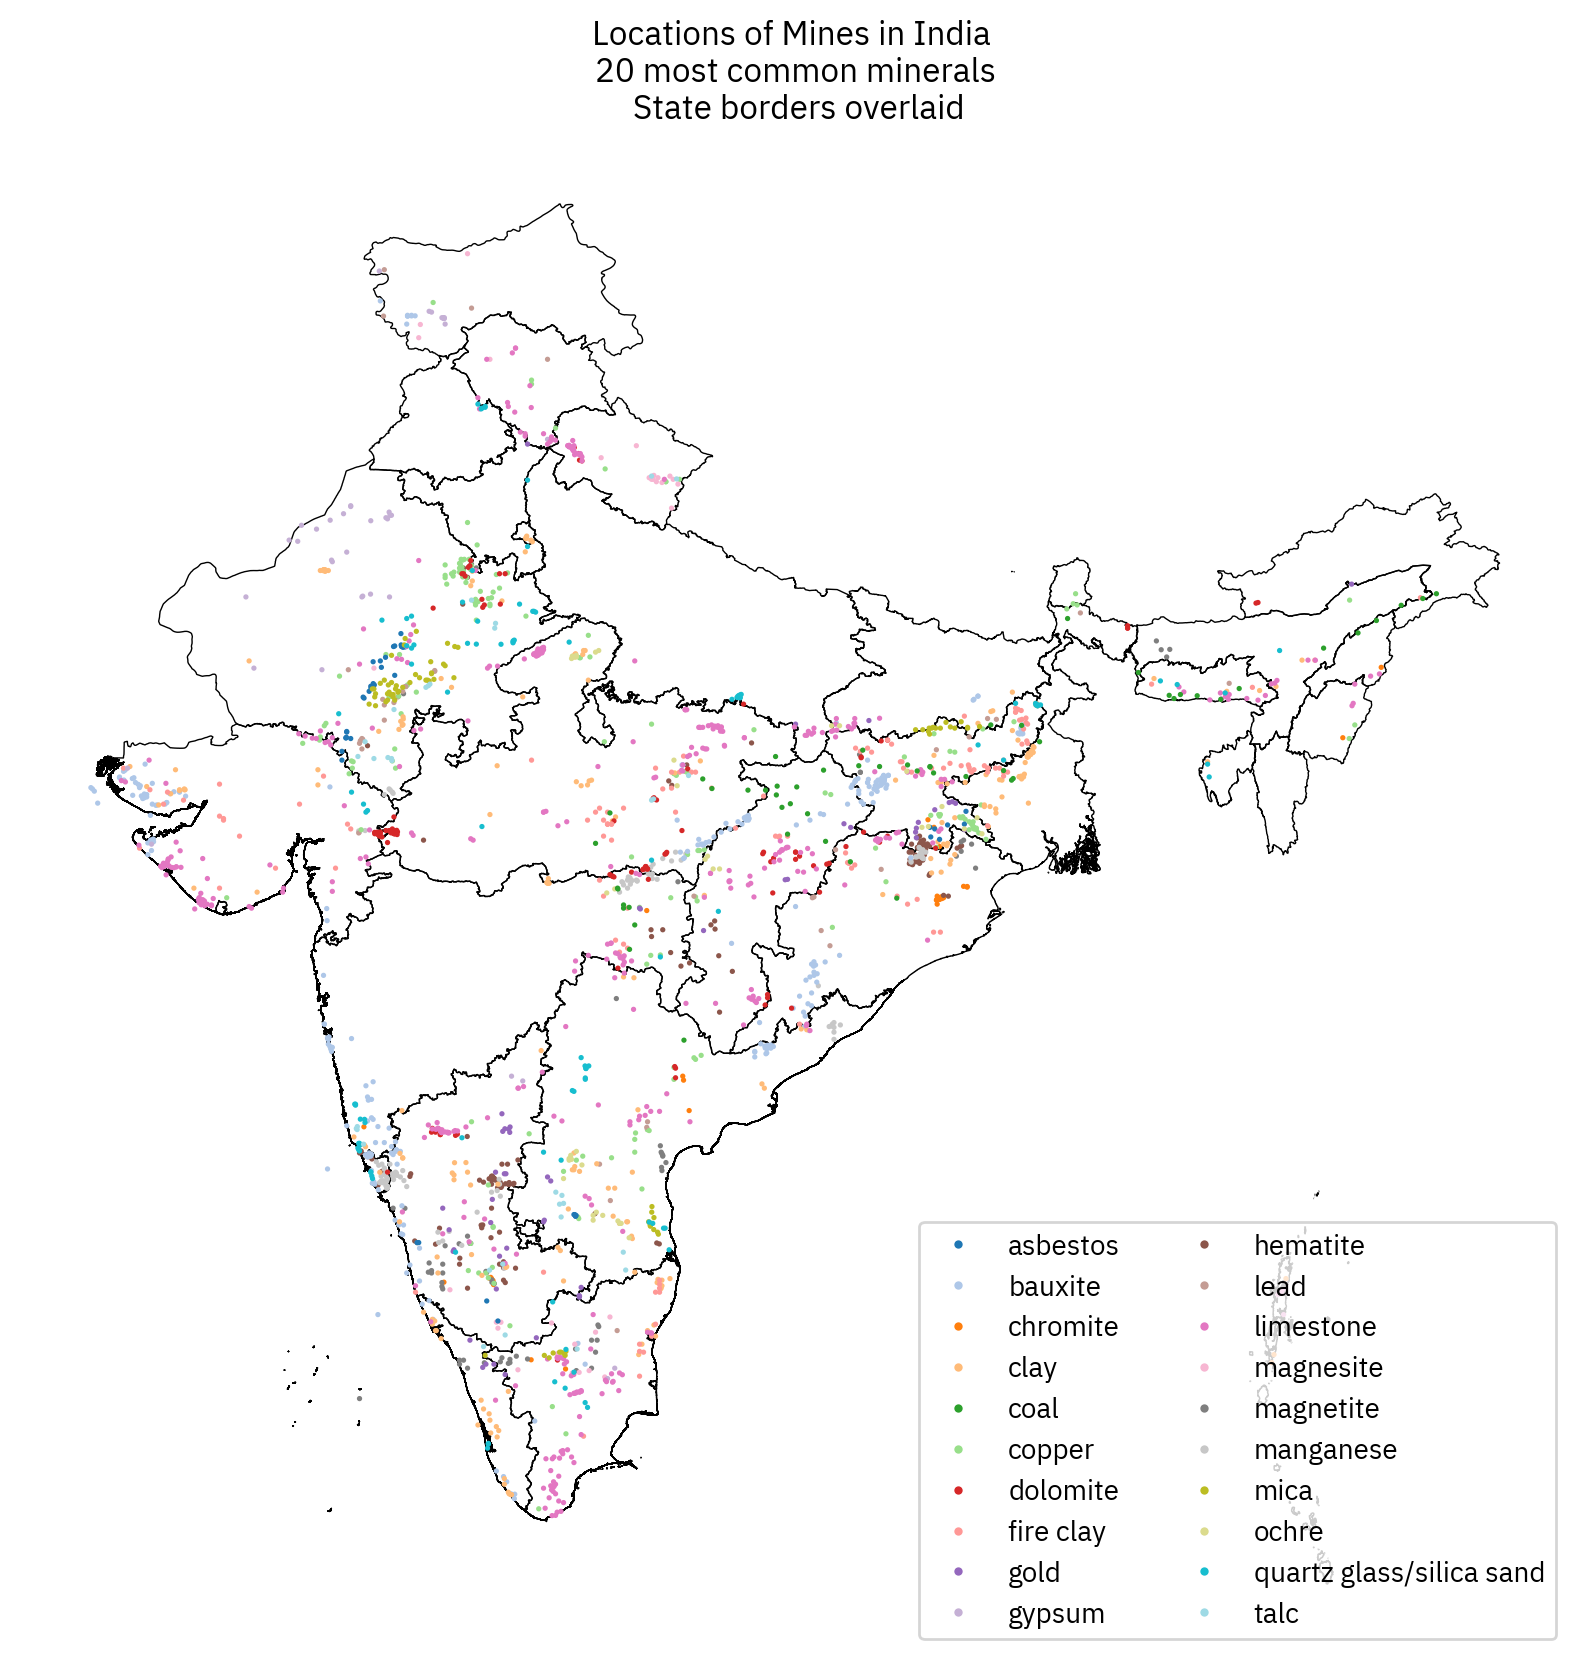

In [28]:
f, ax = plt.subplots(1,figsize = (10, 12), dpi = 200)
states.plot(facecolor = 'None',linewidth = 0.5, edgecolor = 'k', ax = ax)
mines.loc[mines.mineral.isin(top20)].plot(column = 'mineral', categorical = True, 
            markersize = 0.8 , ax = ax,
            legend = True, cmap = 'tab20',
            legend_kwds = {
                'loc': 'lower right', 'markerscale': 0.3, 'ncol': 2,
                'prop': {'size': 10}})
ax.set_axis_off()
ax.set_title("Locations of Mines in India \n 20 most common minerals \n State borders overlaid")
f.savefig(root/'Output/mine_map.pdf')

### Iron

In [15]:
iron = mines.query('metal_class == "Iron and Ferro-Alloy Metals"')
iron.shape

(427, 17)

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Locations of Iron Mines in India \n State borders overlaid')

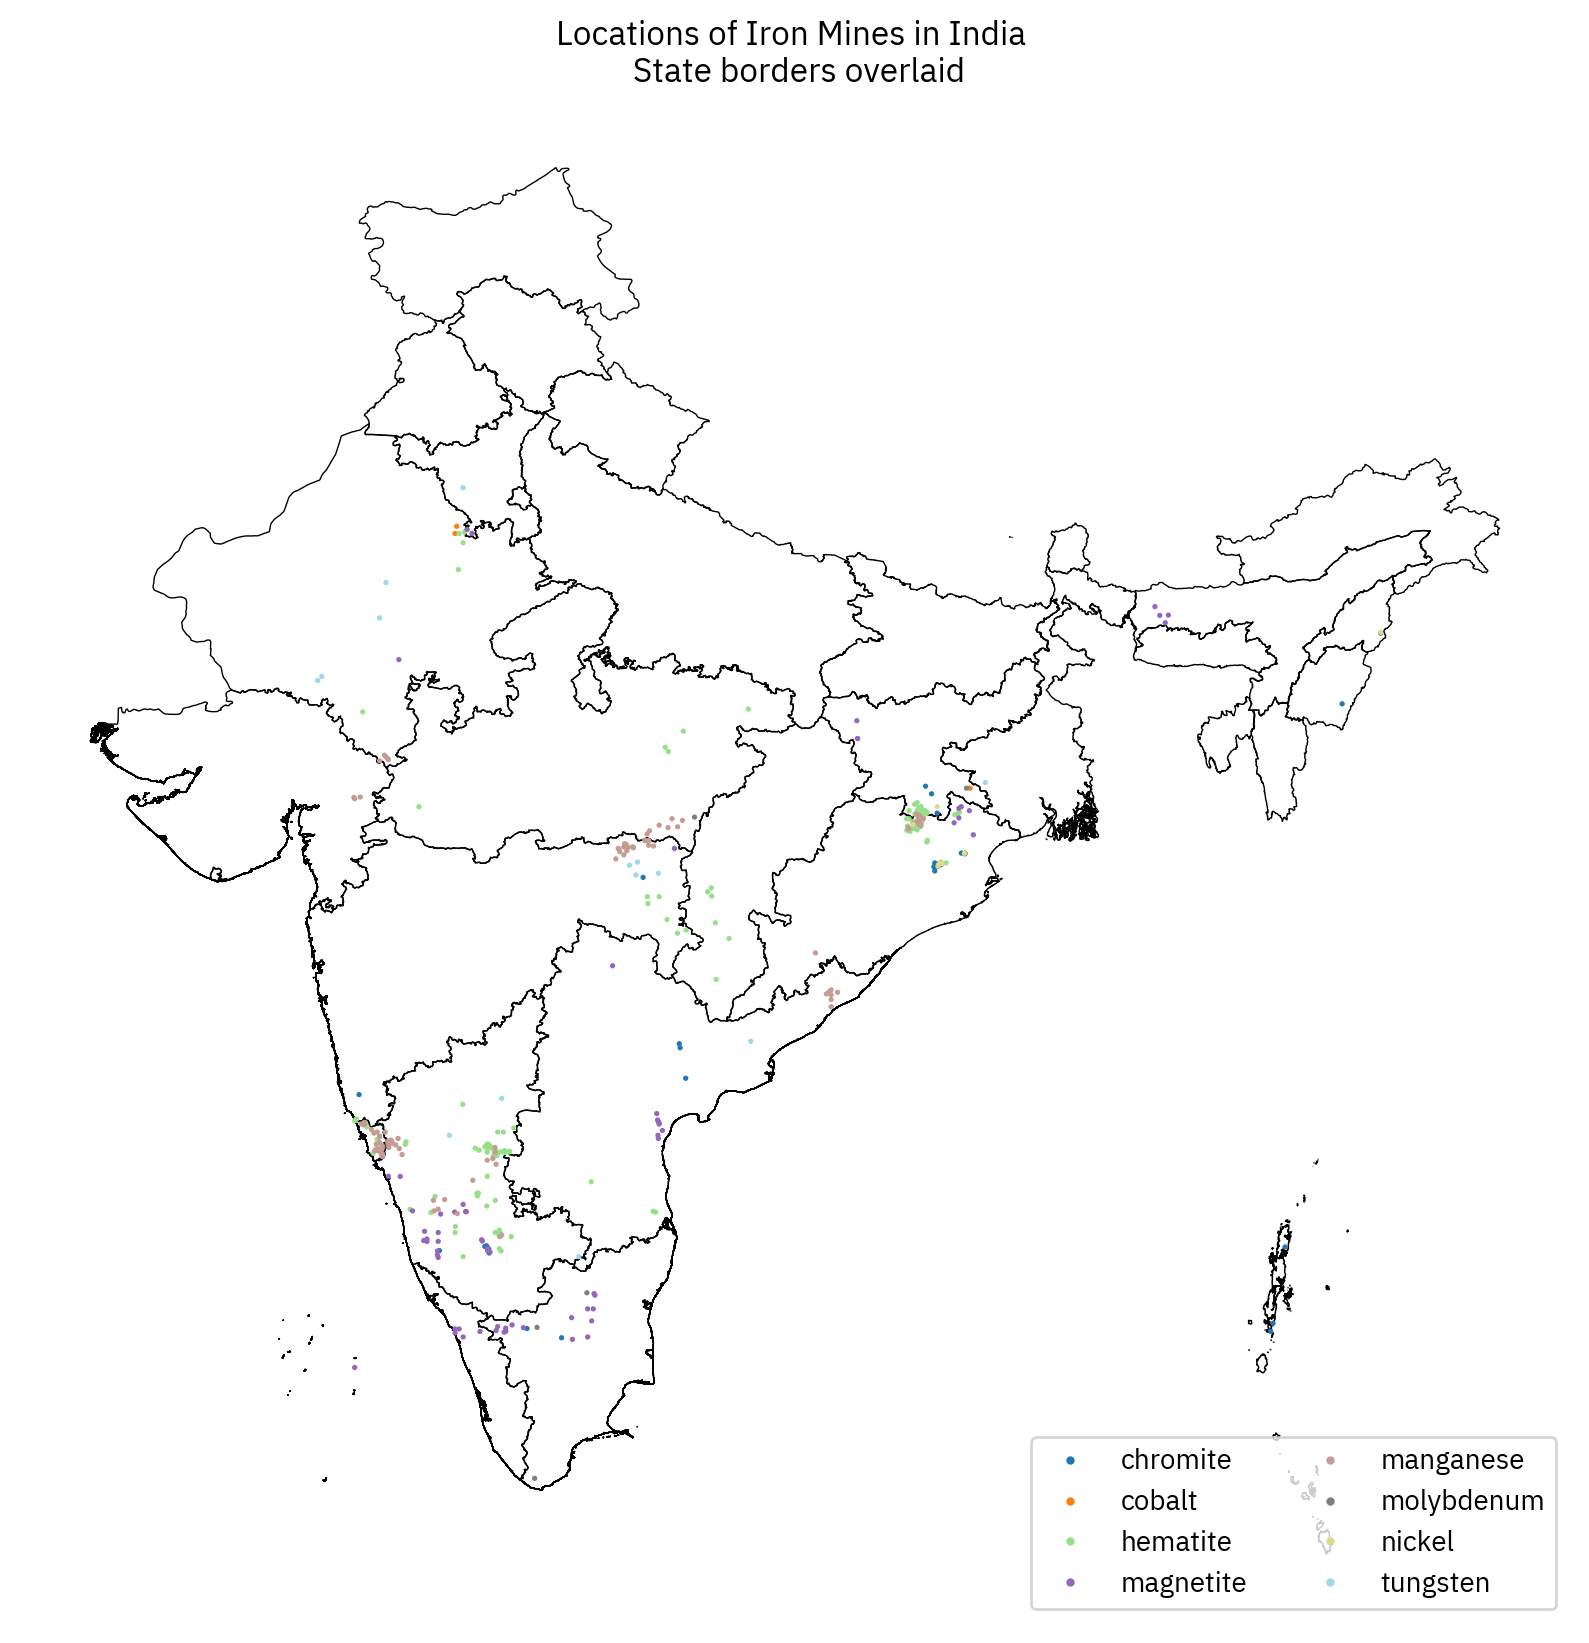

In [17]:
f, ax = plt.subplots(1,figsize = (10, 12), dpi = 200)
states.plot(facecolor = 'None',linewidth = 0.5, edgecolor = 'k', ax = ax)
iron.plot(column = 'mineral', categorical = True, 
            markersize = 0.8 , ax = ax,
            legend = True, cmap = 'tab20',
            legend_kwds = {
                'loc': 'lower right', 'markerscale': 0.3, 'ncol': 2,
                'prop': {'size': 10}})
ax.set_axis_off()
ax.set_title("Locations of Iron Mines in India \n State borders overlaid")
f.savefig(root/'Output/iron_mine_map.pdf')

# Distance to Mines computation 

In [14]:
%%time 
vil = pd.read_csv(data / 'Intermediate/villages_points_all2.csv')

<string>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 3.68 s, sys: 624 ms, total: 4.3 s
Wall time: 4.3 s


In [15]:
vil_g = gpd.GeoDataFrame(vil, geometry=gpd.points_from_xy(vil.lon, vil.lat))

## Distance Computation - overall

In [ ]:
index = rtree.index.Index()
for ind, row in mines.iterrows():
    geom1 = shape(row['geometry'])
    index.insert(ind, geom1.bounds)

In [ ]:
nearest_segment     = lambda x: list(index.nearest(x.bounds, 1))[0]
distance_to_nearest = lambda x: mines.distance(x).min()

In [ ]:
%%time
vil_g['min_dist_to_mine'] = vil_g.geometry.apply(distance_to_nearest)
vil_g['nearest_mine_id']  = vil_g.geometry.apply(nearest_segment)

In [ ]:
Client().send_message("Mine Distance Computation done")

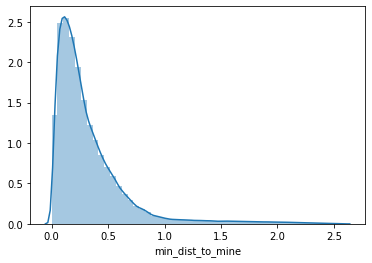

In [39]:
sns.distplot(vil_g.min_dist_to_mine)

### By mineral 

In [16]:
minerals = mines.mineral.unique()

In [17]:
def distance_compute(m):
    mines_subset = mines.loc[mines.mineral == m]
    distance_to_mine = lambda x: mines_subset.distance(x).min()
    d = vil_g.geometry.apply(distance_to_mine)

In [18]:
%%time
distances = Parallel(n_jobs = 10, verbose = 50)(delayed(
    distance_compute)(m) for m in minerals
    )
Client().send_message("Mineral-wise distance Computation done")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:  3.8min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:  5.4min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

### collate and write 

In [45]:
distances_df = pd.concat(distances, axis = 1)
distances_df.columns = ['min_dist_to_' + re.sub("( |/)", "", m) for m in minerals]

In [46]:
vil2 = pd.concat([vil_g, distances_df], axis = 1)

### Write 

In [47]:
vil2 = pd.DataFrame(vil2.drop('geometry', axis = 1))

In [49]:
vil2.to_csv(data/"Intermediate/village_points_all_mines.csv")